# Simulate and visualize the channe frequency response of a TDL channel

Here in this notebook we will show the frequence response of a channel generated with the TDL (Tapped Delay Line) channel model using a jakes fading generator.

First some initializations.

In [1]:
%matplotlib inline

In [2]:
import math
import sys

from matplotlib import pyplot as plt

from pyphysim.channels import fading, fading_generators
from pyphysim.util.conversion import linear2dB

Now we configure the system parameters.

In [3]:
maxSystemBand = 40e6  # 40 MHz (maximum) bandwidth
# Number of subcarriers in this bandwidth
max_num_of_subcarriers = math.floor(maxSystemBand/15e3)
# Find the maximum FFT size we can use which is below than or equal
# to maxNumOfSubcarriersInt
max_num_of_subcarriers = int(
    2 ** math.floor(math.log(max_num_of_subcarriers, 2)))

# Calculate the actual bandwidth that we will used. 
# This will be lower than maxSystemBand
bandwidth = 15e3 * max_num_of_subcarriers

# Total number of subcarriers
total_carriers = max_num_of_subcarriers

Considering a band of 40MHz we can fit 2048 subcarriers. Thus we will actually use a bandwidth of $2018 * 15000 = 30.72$ MHz.

Now let's set the Jakes related parameters.

In [4]:
Fd = 5     # Doppler frequency (in Hz)
Ts = 1./bandwidth  # Sampling interval (in seconds)
NRays = 16  # Number of rays for the Jakes model

jakes = fading_generators.JakesSampleGenerator(Fd, Ts, NRays)

print("The sampling time for this bandwidth is: {0}".format(Ts))

The sampling time for this bandwidth is: 3.2552083333333335e-08


For the TDL parameters, we will use the COST259_TU profile. This will give us the followinf tap powers and delays.

In [5]:
tap_powers = np.array([-5.7, -7.6, -10.1, -10.2, -10.2, -11.5, -13.4,
                       -16.3, -16.9, -17.1, -17.4, -19.0, -19.0, -19.8,
                       -21.5, -21.6, -22.1, -22.6, -23.5, -24.3])
tap_delays = np.array([0, 0.217, 0.512, 0.514, 0.517, 0.674, 0.882,
                       1.230, 1.287, 1.311, 1.349, 1.533, 1.535, 1.622,
                       1.818, 1.836, 1.884, 1.943, 2.048, 2.140]) * 1e-6

num_included_taps = tap_delays.size

Now we can finally create thr TDL channel object.

In [6]:
tdlchannel = fading.TdlChannel(jakes, tap_powers_dB=tap_powers[0:num_included_taps], tap_delays=tap_delays[0:num_included_taps])

From the TDL channel object we can get the fading map containing the frequency response of the channel.

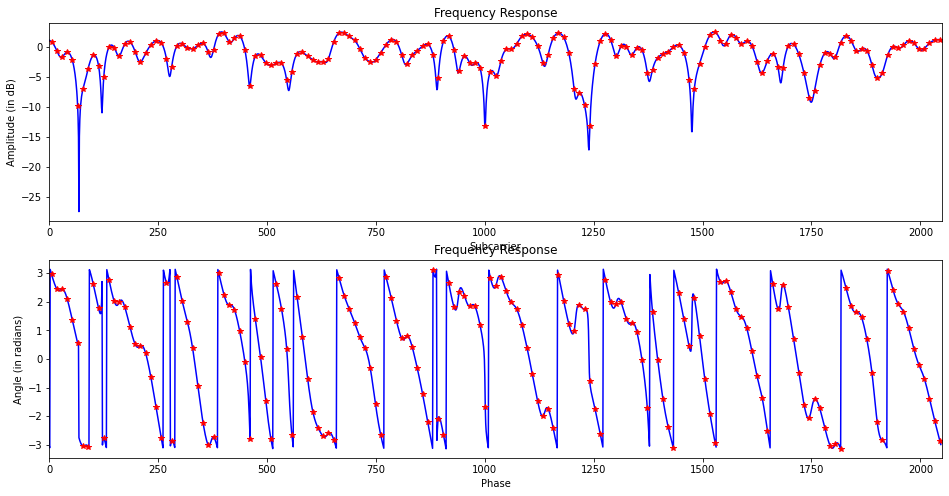

In [7]:
# NSamples = 1  # We will generate the map for only 1 TTI

tdlchannel.generate_impulse_response()
last_impulse_response = tdlchannel.get_last_impulse_response()
freqResponse = last_impulse_response.get_freq_response(total_carriers)


# Get the freq response only in the PRBs
central_carriers = np.r_[5:total_carriers:12]
prbsFreqResponse = freqResponse[central_carriers,:]

# xxxxxxxxxx Plot the amplitude and phase xxxxxxxxxxxxxxxxxxxxxxxx
plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
plt.plot(linear2dB(np.abs(freqResponse[:total_carriers,0])),'b')
plt.plot(central_carriers, linear2dB(np.abs(prbsFreqResponse[:,0])),'*r')
#plt.plot(central_carriers, np.abs(freqResponse[central_carriers,99]),'g*')
plt.title('Frequency Response')
plt.ylabel('Amplitude (in dB)')
plt.xlabel('Subcarrier')
plt.xlim((0,2050))

plt.subplot(2,1,2)
plt.plot(np.angle(freqResponse[:total_carriers,0]),'b')
plt.plot(central_carriers, np.angle(prbsFreqResponse[:,0]),'*r')
#plt.plot(central_carriers, np.abs(freqResponse[central_carriers,99]),'g*')
plt.title('Frequency Response')
plt.ylabel('Angle (in radians)')
plt.xlabel('Phase')
plt.xlim((0,2050))

plt.show()

# Get the impulse response of a subset of subcarriers

Let's select a subset of the subcarriers, for instance 300 subcarriers.

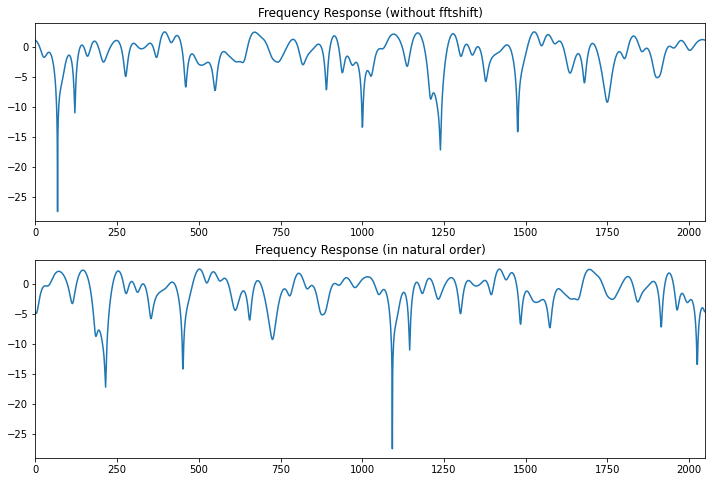

In [8]:
naturalFreqResponse = np.fft.fftshift(freqResponse)

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(linear2dB(np.abs(freqResponse)))
plt.xlim(0,2048)
plt.title("Frequency Response (without fftshift)")
plt.subplot(2,1,2)
plt.plot(linear2dB(np.abs(naturalFreqResponse)))
plt.xlim(0,2048)
plt.title("Frequency Response (in natural order)")
plt.show()

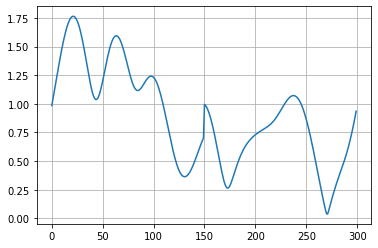

In [9]:
# Let's get a subset of 300 subcarriers
startIdx = 331  # Index of the first subcarrier
num_subcarriers_subset = 300
naturalFreqResponse_300 = naturalFreqResponse[startIdx:startIdx+num_subcarriers_subset].flatten()
freqResponse_300 = np.fft.ifftshift(naturalFreqResponse_300)
plt.plot((np.abs(freqResponse_300)))
plt.grid()
plt.show()

Notice how we have a **suddenly change** at some point in the frequency response.

Now let's calculate the impulse response only on this subset.

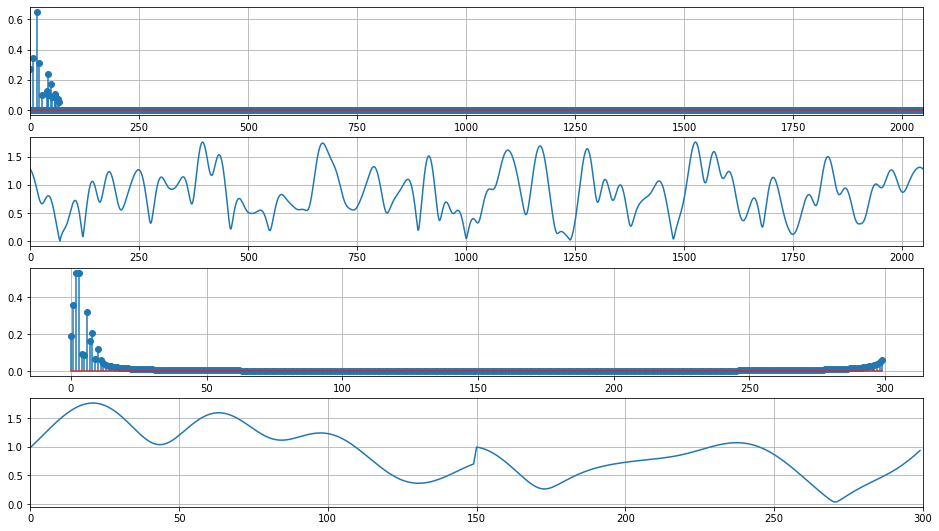

In [10]:
# Impulse response considering all subcarriers
impulse_response = np.fft.ifft(freqResponse,axis=0)
# Impulse response considering only the selected 300 subcarriers
impulse_response_300 = np.fft.ifft(freqResponse_300,axis=0)

plt.figure(figsize=(16,14))
plt.subplot(6,1,1)
plt.stem(np.abs(impulse_response), use_line_collection=True)
plt.grid()
plt.xlim(0,2048)

plt.subplot(6,1,2)
plt.plot(np.abs(np.fft.fft(impulse_response.flatten())))
plt.xlim(0,2048)
plt.grid()


plt.subplot(6,1,3)
plt.stem(np.abs(impulse_response_300), use_line_collection=True)
plt.grid()


plt.subplot(6,1,4)
plt.plot(np.abs(np.fft.fft(impulse_response_300.flatten())))
plt.xlim(0,300)
plt.grid()

# plt.subplot(6,1,5)
# plt.stem(np.abs(impulse_response_300_fixed))
# plt.grid()

# plt.subplot(6,1,6)
# impulse_response_300_fixed = np.copy(impulse_response_300)
# impulse_response_300_fixed[-30:] = 0.0
# plt.plot(np.abs(np.fft.fft(impulse_response_300_fixed.flatten())))
# plt.xlim(0,300)
# plt.grid()


plt.show()

In [11]:
impulse_response.shape

(2048, 1)

# Interpolating the PRB frequency response to get the full map

The interpolation will be performed using the IFFT followes by a larger FFT.

First let's get the original impulse response.

In [12]:
H = freqResponse[:,0]
h = np.fft.ifft(H, total_carriers)
print("H.size: {0}".format(H.size))

H.size: 2048


Now let's get the impulse response considering we only know the channel at the central subcarriers in each PRB.

In [13]:
sampled_H = prbsFreqResponse[:,0]
sampled_h = np.fft.ifft(sampled_H)
print("H.size: {0}".format(sampled_H.size))

H.size: 171


For comparison we can plot both impulse responses

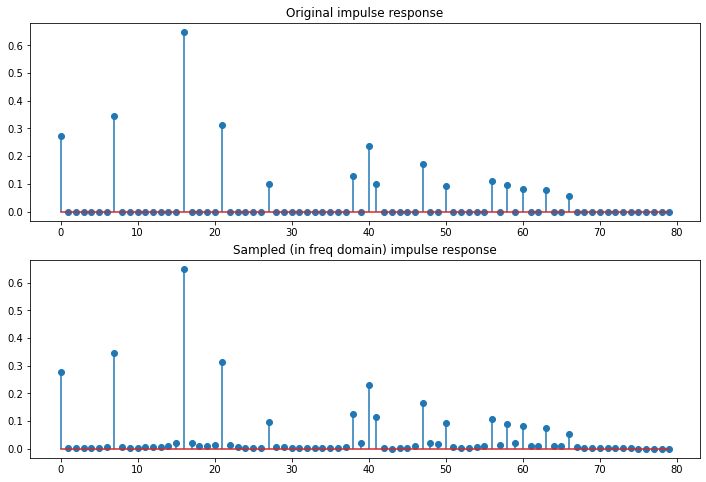

Squared error (max): 0.2249492258890579


In [14]:
# Note that h has 2048 elements but we now only the first ones are different from zero
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.stem(abs(h[0:80]), use_line_collection=True)
plt.title('Original impulse response')
plt.subplot(2,1,2)
plt.stem(abs(sampled_h[0:80]), use_line_collection=True)
plt.title('Sampled (in freq domain) impulse response')
plt.show()

# The error is not very high, but there is some error
squared_error = np.max(np.abs(sampled_h[0:171] - h[0:171]))
print("Squared error (max): {0}".format(squared_error))

But the sampled_H **has dimension of only 171** (the number of PRBs in the configured bandwidth). We want it to have dimension equal to total_carriers. For that we will **compute the FFT of sampled_h** with total_carriers size.

In [15]:
new_H = np.fft.fft(sampled_h, total_carriers)

new_h = np.fft.ifft(new_H)

Now let's plot the horiginal frequency response and our interpolated frequency response. Note that the interpolated channel **new_H** starts at the central subcarrier of the first PRB. Thus in the plot we include the true channel starting at subcarrier 7.

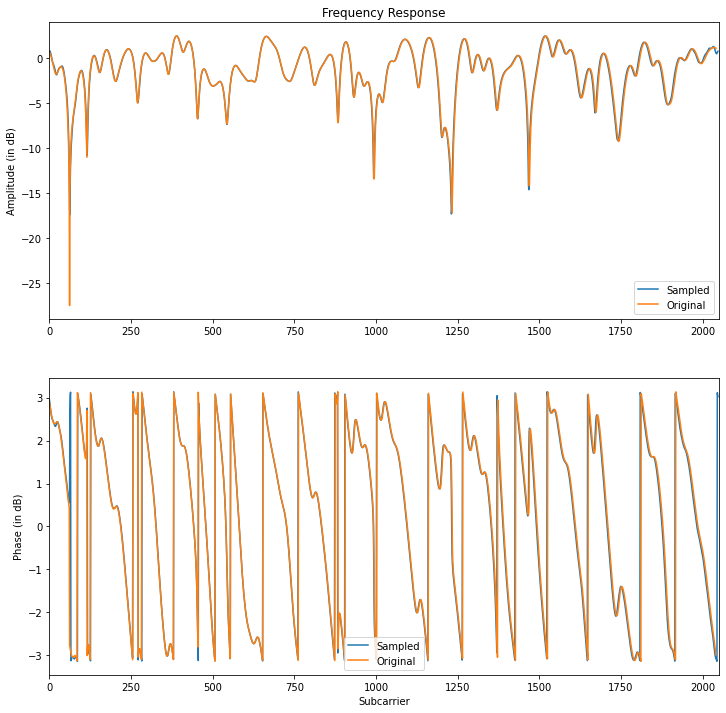

In [16]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.title("Frequency Response")
plt.plot(linear2dB(np.abs(new_H)))
plt.xlim(0,2050)
# plt.hold(True)
plt.plot(linear2dB(np.abs(H[6:])))
plt.legend(['Sampled', 'Original'], loc='best')
plt.ylabel('Amplitude (in dB)')

plt.subplot(2,1,2)
plt.plot((np.angle(new_H)))
# plt.hold(True)
plt.plot((np.angle(H[6:])))
plt.legend(['Sampled', 'Original'])
plt.ylabel('Phase (in dB)')
plt.xlabel('Subcarrier')
plt.xlim(0,2050)

plt.show()